In [17]:
import os,sys
ROOT_DIR = os.path.abspath("../../")
DATA_DIR = os.path.join(ROOT_DIR, 'data/processed')
sys.path.append(ROOT_DIR)  # To find local version of the library

import pandas as pd
import numpy as np
import imageio as iio
import json
from skimage.draw import polygon
import matplotlib.pyplot as plt
import skimage
from typing import Union
import helper as hp
from models.maskrcnn.mrcnn import visualize,utils



In [2]:
# checking for labels of interest
# labels of interest
keeplabels ={'road':7,
            'sidewalk':8,
            'rail track':10,
            'wall':12,
            'fence':13,
            'guard rail':14,
            'pole':17,
            'polegroup':18,
            'vegetation': 21,
            'car':26,
            'bicycle':33}
inv_keeplabels =  {
    7: 'road',
    8: 'sidewalk',
    10: 'rail track',
    12: 'wall',
    13: 'fence',
    14: 'guard rail',
    17: 'pole',
    18:  'polegroup',
    21: 'vegetation',
    26: 'car',
    33: 'bicycle'}


In [3]:
IMG_DIR = os.path.join(DATA_DIR, 'images')
LBL_DIR = os.path.join(DATA_DIR, 'segmentations')

# x_train, y_train = IMG_DIR + '/train', LBL_DIR+'/train'
# x_test, y_test = IMG_DIR + '/test', LBL_DIR+'/test'
# x_val , y_val =IMG_DIR + '/val', LBL_DIR+'/val'

In [4]:
txt = os.path.join(DATA_DIR, 'keep_img_ids.txt')
with open(txt,'r') as f:
    keep_ids = f.readlines()
    keep_ids = [k[:-1] for k in keep_ids]

In [16]:
def getInstances(filename:str, labelsToKeep:dict):
    labels = []
    keys = labelsToKeep.keys()
    data = json.load(open(filename))
    data = data["objects"]
    for d in data:
        l = d['label']
        if l in keys:
            labels.append(labelsToKeep[l])
    return labels

def getLabels(ids, y_directory,keepLabels=keeplabels):
    labels = []
    for id in ids:
        # city= id.split('_')[0]
        # im_path = os.path.join(x,ci ty,id+'_leftImg8bit.png')
        lb_path = os.path.join(y_directory, id+'.json')
        labels.append(getInstances(lb_path,keepLabels))
    return labels

def generateCSV(filepath:str, ids, labels):
    df = pd.DataFrame(data=list(zip(ids, labels)),columns=['ID','LABEL'])
    df.to_csv(filepath, index=False)
    

In [11]:
# val_labels = hp.getLabels(keep_ids,LBL_DIR)
# generateCSV('/Users/csea/Desktop/deep-learning-final-project-project-sidewalk/data/processed/labels.csv',keep_ids,val_labels)

# IOU for labeling

In [5]:
IMG_DIR = os.path.join(DATA_DIR, 'images')
LBL_DIR = os.path.join(DATA_DIR, 'segmentations')

# reading label data
df = pd.read_csv(os.path.join(DATA_DIR,'labels_road.csv'),index_col=None)
df.head()
data = df.set_index('ID').T.to_dict('list')
for k in data:
    data[k] = [i.split(' ')[:-1] for i in data[k]][0]
    data[k] = np.array([int(i) for i in data[k]])


# generate all labels for each sample
sample_labels = [data[id] for id in data]

data_mask = {}
for id in data:
    masks = hp.stack_mask(id, data,(256,512), road=True)
    data_mask[id] = masks

In [159]:
from sklearn.metrics import jaccard_score

def generate_ious(labels, masks,sidewalk_lbl=8, IOU_THRESHOLD=0.001, road_lbl=None):
    '''
    Generates the ious for all the segmentations against all instances 
    of sidewalk masks.

    Returns dictionary of format {label_index: (label_index, ious_score)}
    '''

    # want to change this so that if there is 
    sidewalk_idx = np.where(labels==sidewalk_lbl)[0]
    if road_lbl:
        road_idx = np.where(labels==road_lbl)[0]

    # sidewalk_masks = masks[:,:, sidewalk_idx]

    all_labels = np.unique(labels)
    ious = {}

    for label in all_labels:
        if label == sidewalk_lbl: continue
        if road_lbl and label==road_lbl: continue

        for sidewalk in sidewalk_idx:
            sidewalk_mask = masks[:,:,sidewalk]
            non_sidewalk = np.where(labels==label)[0]
            for i in non_sidewalk:
                iou = jaccard_score(sidewalk_mask, masks[:,:,i],average='micro',zero_division={0.0, 1.0})

                # if IOU(car, road)>0: ignore this car
                if road_lbl and labels[i]==26:
                    for road in road_idx:
                        road_mask = masks[:,:,road]
                        iou = jaccard_score(road_mask, masks[:,:,i],average='micro',zero_division={0.0, 1.0})
                        # print(i,iou)
                        if iou>0:
                            iou =0

                
                if iou >= IOU_THRESHOLD:
                    if i not in ious:
                        ious[i] = (sidewalk, iou)
                    else:
                        if ious[i][-1] < iou:
                            ious[i] = (sidewalk,iou)
    return ious

def generate_obstruction_labels(instance_labels, ious):
    obstruction_labels = ''
    for i in range(len(instance_labels)):
        if instance_labels[i]==7:
            continue
        lab = 0
        if i in ious:
            lab = 1
        # obstruction_labels.append(lab)
        obstruction_labels += str(lab)+' '

    # return ' '.join(str(i) for i in obstruction_labels)
    return obstruction_labels

def generateCSV(filepath:str, ids, labels,obstruction_label=None):
    row = zip(ids,labels)
    if obstruction_label:
        row = zip(ids,labels,obstruction_label)
        cols = ['ID','LABEL','OBSTRUCTION']
    df = pd.DataFrame(data=list(row),columns=cols)
    df.to_csv(filepath, index=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


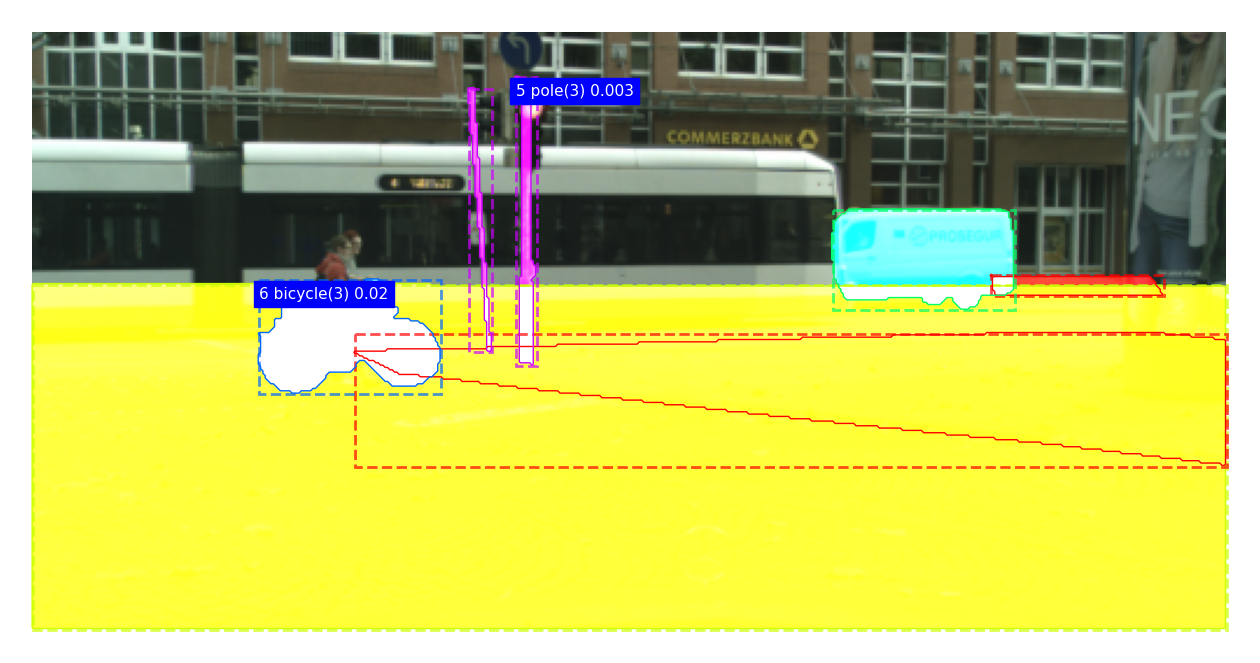

'0 0 0 0 1 1 '

In [154]:
# checking
id= 'bremen_000073_000019'

img = plt.imread(f'{IMG_DIR}/{id}.png')
img = skimage.transform.resize(img, (256,512))
labels= data[id]
masks = data_mask[id]
bboxes = utils.extract_bboxes(masks)

iou = generate_ious(labels, masks, road_lbl=7)
captions = hp.generate_captions_obstructed(labels, iou)
visualize.display_instances(img,bboxes,masks,labels,inv_keeplabels, captions=captions)
generate_obstruction_labels(labels,iou)


In [150]:
# writing the new labels
df = pd.read_csv(os.path.join(DATA_DIR,'labels.csv'),index_col=None)
df_ids = df['ID'].tolist()
df_labs = df['LABEL'].tolist()

In [157]:
df_obstructions = []
for (i,id) in enumerate(df_ids):
    if i % 50==0:
        print(i)
    labels= data[id]
    masks = data_mask[id]
    iou = generate_ious(labels, masks, road_lbl=7)
    obs = generate_obstruction_labels(labels,iou)
    df_obstructions.append(obs)


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250


In [160]:
generateCSV(os.path.join(DATA_DIR,'labels_obs.csv'),df_ids,df_labs,df_obstructions)